In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

In [8]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [47]:
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
num_nodes = 3
net = Net(num_nodes=3)
    

print(net)


Net(
  (fc1): Linear(in_features=4, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=3, bias=True)
)


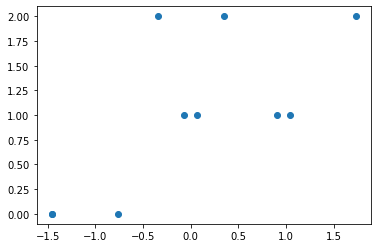

In [20]:
from sklearn.datasets import load_iris
import numpy as np
np.random.seed(0)
device  =torch.device('cpu')
data = load_iris()
x_ = data['data']
y_ = data['target']
N_tr = 10#50
N_val = 140
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [40]:
x_train.shape

torch.Size([10, 4])

In [43]:
x_val.shape

torch.Size([140, 4])

In [45]:
net(x_val)

torch.Size([140, 3])

In [21]:
## Set hyperparameters for network

tau_list = []
tau = 1.#/100. # iris 1/10
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [38]:
hamiltorch.set_random_seed(123)
params_init = hamiltorch.util.flatten(net).to(device).clone()

step_size = 0.15 
num_samples = 5000
burn = 1000
L = 20
tau_out = 1.
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC_NUTS
params_hmc = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,tau_list=tau_list,
                                    sampler=sampler, integrator=integrator, burn=burn)

Sampling (Sampler.HMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec


KeyboardInterrupt: 

In [33]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=params_hmc[:], model_loss='multi_class_linear_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc = torch.zeros( len(pred_list)-1)
nll = torch.zeros( len(pred_list)-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)
for s in range(1,len(pred_list)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc[s-1] = (pred.float() == y_val.flatten()).sum().float()/y_val.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
    nll[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_val[:].long().cpu().flatten(), reduction='mean')

CPU times: user 3.64 s, sys: 7.96 ms, total: 3.65 s
Wall time: 3.65 s


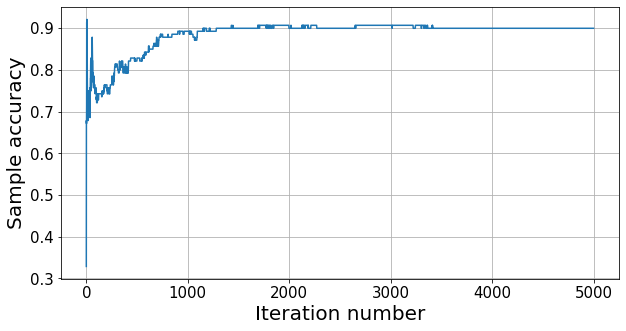

In [34]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc)
plt.grid()
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

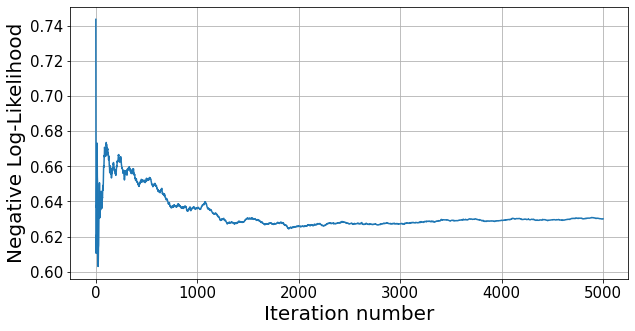

In [35]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(nll)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log-Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

# Draw subset of samples

In [51]:
hmc_weights = torch.empty([0])
for w in params_hmc:
    hmc_weights = torch.cat([hmc_weights, w[None]])

In [20]:
g = torch.Generator()
g.manual_seed(0)
perm = torch.randperm(hmc_weights.size(0), generator=g)
num_s = 500
idx = perm[:num_s]
samples = hmc_weights[idx]
samples_rest = hmc_weights[perm[num_s:]]

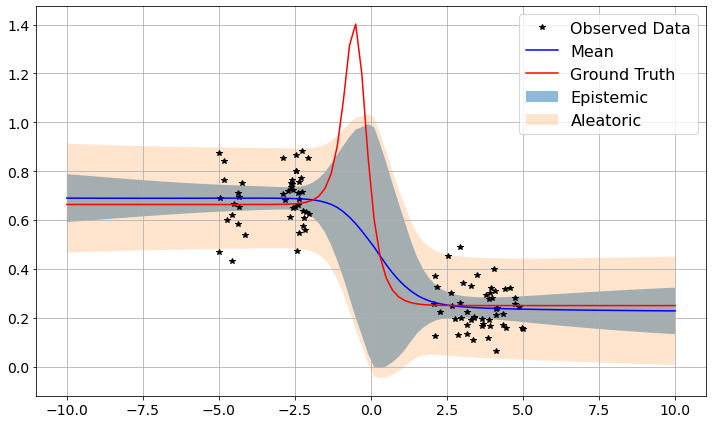

In [21]:
# Let's predict over the entire test range [-2,2]
pred_list_hmc_subsample, _ = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=samples,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_hmc_subsample)

# Build a KDE

In [61]:
import torch
import torch.distributions as D
from torch import nn
from torch.nn import functional as F

class BNN_KDE(nn.Module):
    def __init__(self, emp_samples, input_size=4, num_nodes=2, output_size=3, alpha=1., kl_beta=1.,
                 initial_rho=-3.0):
        super(BNN_KDE, self).__init__()
        self.register_buffer('emp_samples', emp_samples)
        self.log_kde_rho = nn.Parameter(torch.tensor([initial_rho]))
        self.prior_alpha = alpha
        self.weight_prior = D.Normal(loc=0., scale=1. / alpha ** 0.5)
        self.activation = nn.Tanh()
        self.input_size = input_size
        self.num_nodes = num_nodes
        self.output_size = output_size
        self.kl_beta = kl_beta

    @property
    def kde(self):
        batch_dim, problem_dim = self.emp_samples.shape
        mixture_weights = D.Categorical(probs=torch.ones(batch_dim))
        kde_var = F.softplus(self.log_kde_rho, beta=1.) ** 2
        covariances = torch.eye(problem_dim)
        gaussian_components = D.MultivariateNormal(loc=self.emp_samples,
                                                   covariance_matrix=kde_var * covariances)

        return D.MixtureSameFamily(mixture_weights, gaussian_components)

    def sample_from_kde(self, n_samples):
        kde_std = F.softplus(self.log_kde_rho, beta=1.)
        # first need to randomly sample indices for which component to choose
        rand_idxs = torch.randint(low=0, high=self.emp_samples.shape[0], size=(n_samples,))

        # create batch of eps ~ N(0, I)
        eps = torch.randn(size=(n_samples, self.emp_samples.shape[-1]))

        # for each chosen idx, sample from that mixture component
        chosen_emp_samples = self.emp_samples[rand_idxs]

        samples = chosen_emp_samples + eps * kde_std

        return samples
    
    def batch_predict(self, weight_samples, x_data):
        # get shapes
        batch_x_dim = x_data.shape[0]
        n_samples = weight_samples.shape[0]
        # create batches of layers from posterior sample
        idx = 0
        layer_1_w = weight_samples[:, idx:idx + self.num_nodes]
        idx += self.num_nodes
        layer_1_b = weight_samples[:, idx:idx + self.num_nodes]
        idx += self.num_nodes
        layer_2_w = weight_samples[:, idx:idx + self.num_nodes * self.num_nodes].reshape(n_samples, self.num_nodes,
                                                                                         self.num_nodes)
        idx += self.num_nodes * self.num_nodes
        layer_2_b = weight_samples[:, idx:idx + self.num_nodes]
        idx += self.num_nodes
        layer_3_w = weight_samples[:, idx:idx + self.num_nodes]
        idx += self.num_nodes
        layer_3_b = weight_samples[:, idx]

        # compute activations for layer one
        x_data = torch.einsum("bi, kj -> bki", layer_1_w, x_data) + layer_1_b[:, None].repeat(1, batch_x_dim, 1)
        x_data = self.activation(x_data)

        # compute activations for layer 2
        x_data = torch.einsum("bij, bkj -> bki", layer_2_w, x_data) + layer_2_b[:, None].repeat(1, batch_x_dim, 1)
        x_data = self.activation(x_data)

        # compute final output
        x_data = torch.einsum("bi, bki -> bk", layer_3_w, x_data) + layer_3_b[:, None].repeat(1, batch_x_dim)

        return x_data

    def data_likelihood(self, y_preds, y_data):
        pred_dist = F.softmax(y_preds, dim=-1)
        return F.nll_loss()

    def weight_prior_lp(self, weight_samples):
        return self.weight_prior.log_prob(weight_samples).sum(1)


    def elbo(self, x, y, n_samples):
        # first sample weights from KDE
        weight_samples = self.sample_from_kde(n_samples)
        y_preds = self.batch_regression(weight_samples, x, n_samples)
        weight_prior_lp = self.weight_prior_lp(weight_samples)
        data_likelihood_lp = self.data_likelihood(y_preds, y)
        q_lp = self.kde.log_prob(weight_samples)

        kl_term = q_lp - weight_prior_lp

        return (data_likelihood_lp - self.kl_beta * kl_term).mean()

    def log_q_w(self, weight_samples):
        return self.kde.log_prob(weight_samples).mean()
    
    def reinforce_loss(self, x, y, n_samples):
        # first sample weights from KDE
        weight_samples = self.kde.sample((n_samples,))
        y_preds = self.batch_regression(weight_samples, x, n_samples)
        weight_prior_lp = self.weight_prior_lp(weight_samples)
        data_likelihood_lp = self.data_likelihood(y_preds, y)
        q_lp = self.kde.log_prob(weight_samples)
        
        with torch.no_grad():
            no_grad_elbo = data_likelihood_lp + self.kl_beta * (weight_prior_lp - q_lp)
        reinforce_term_1 = q_lp * no_grad_elbo
        reinforce_term_2 = data_likelihood_lp + self.kl_beta * (weight_prior_lp - q_lp)

        return (reinforce_term_1 + reinforce_term_2).mean()

In [62]:
test = BNN_KDE(hmc_weights, num_nodes=num_nodes)

In [71]:
test.batch_predict(test.sample_from_kde(10), x_train).shape

torch.Size([10, 10])

In [66]:
net(x_train).shape

torch.Size([10, 3])

In [52]:
hmc_weights.shape

torch.Size([5000, 39])

# Let's try the KDE coder

# KDE 100 Samples

In [26]:
# find optimal kde_var
from models.BNNs.BNN_KDE_EQUAL_ISOTROPIC import BNN_KDE
from tqdm.notebook import trange

In [27]:
bnn_kde = BNN_KDE(samples, alpha=alpha, beta=beta, kl_beta=ELBO_BETA)

with torch.no_grad():
    rho_linspace = torch.linspace(-5, -2, 100)
    rho_elbos = torch.zeros_like(rho_linspace)
    for i, rho in enumerate(rho_linspace):
        bnn_kde.log_kde_rho = nn.Parameter(rho)
        rho_elbos[i] = bnn_kde.elbo(x_data, y_data, 512)

In [28]:
initial_rho = rho_linspace[torch.argmax(rho_elbos)].item()

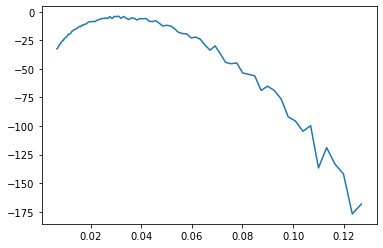

In [29]:
plt.plot(F.softplus(rho_linspace), rho_elbos.numpy())

In [28]:
bnn_kde.log_kde_rho = nn.Parameter(rho_linspace[torch.argmax(rho_elbos)])
KDE_target = bnn_kde.kde

In [29]:
from rec.utils import kl_estimate_with_mc
prior = D.MultivariateNormal(loc=torch.zeros_like(samples[0]), covariance_matrix = 1./alpha * torch.eye(samples.shape[-1]))
kl_q_p = kl_estimate_with_mc(KDE_target, prior)
print(f"{kl_q_p}")

40.4430205067133


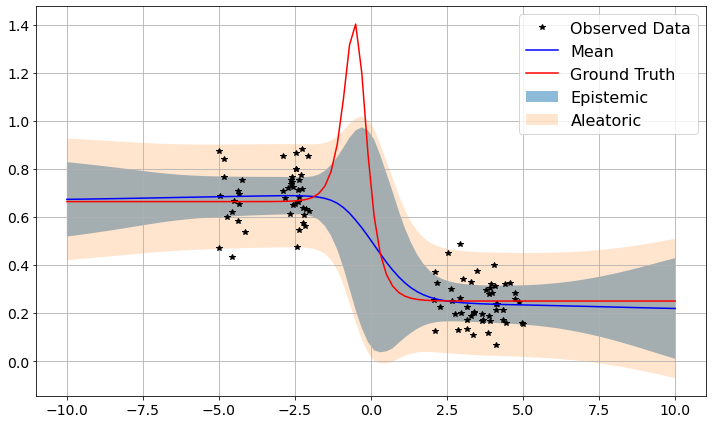

In [35]:
num_compressed_samples = 500
compressed_weights_kde_exact = KDE_target.sample((num_compressed_samples,))

pred_list_kde_exact, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_exact,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_exact)

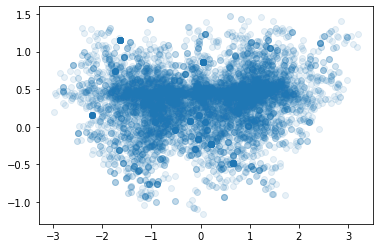

In [40]:
plt.scatter(hmc_weights[:, 0], hmc_weights[:, -1], alpha=0.1)

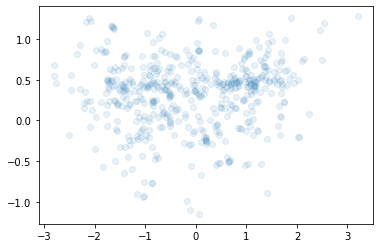

In [41]:
plt.scatter(compressed_weights_kde_exact[:, 0], compressed_weights_kde_exact[:, -1], alpha=0.1)

In [44]:
bnn_kde = BNN_KDE(samples, alpha=alpha, beta=beta, kl_beta=ELBO_BETA, initial_rho=initial_rho)

num_epochs = 100
num_parallel_samples = 128
optimiser = torch.optim.Adam(bnn_kde.parameters(), lr=1e-3)
stds = []
losses = []
for i in trange(num_epochs):
    optimiser.zero_grad()
    loss = -bnn_kde.reinforce_loss(x_data, y_data, num_parallel_samples)
    stds.append(F.softplus(bnn_kde.log_kde_rho.detach()).numpy())
    if i % 10 - 1 == 0:
        losses.append(loss.item())
        print(f'The loss is: {torch.tensor(losses[-10:]).mean():.5f}')
    loss.backward()
    optimiser.step()

  0%|          | 0/100 [00:00<?, ?it/s]

The loss is: -915.96650
The loss is: -931.22045
The loss is: -930.57418
The loss is: -929.84260
The loss is: -928.83959
The loss is: -930.47226
The loss is: -927.93468
The loss is: -928.63100
The loss is: -926.32745


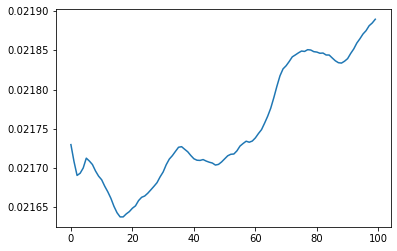

In [45]:
plt.plot(stds)

In [46]:
KDE_target = bnn_kde.kde

In [47]:
from rec.utils import kl_estimate_with_mc
prior = D.MultivariateNormal(loc=torch.zeros_like(samples[0]), covariance_matrix = 1./alpha * torch.eye(samples.shape[-1]))
kl_q_p = kl_estimate_with_mc(KDE_target, prior)
print(f"{kl_q_p}")

40.60215492492757


In [39]:
num_compressed_samples = 250
compressed_weights_kde_exact = KDE_target.sample((num_compressed_samples,))

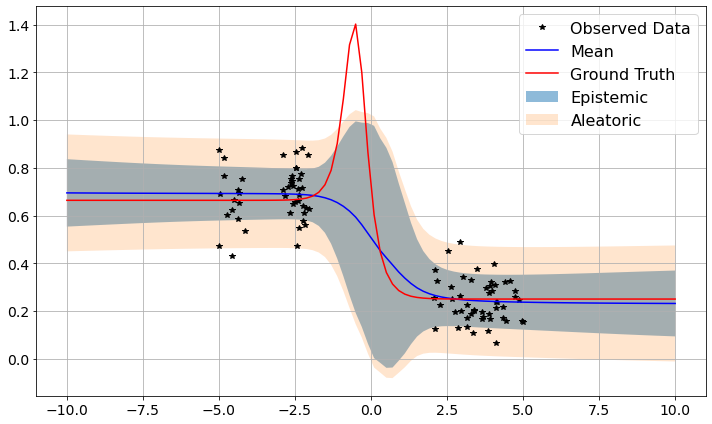

In [40]:
pred_list_kde_exact, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_exact,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_exact)

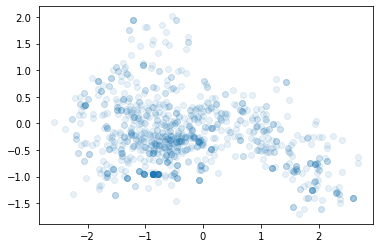

In [41]:
plt.scatter(hmc_weights[:, 0], hmc_weights[:, -3], alpha=0.1)

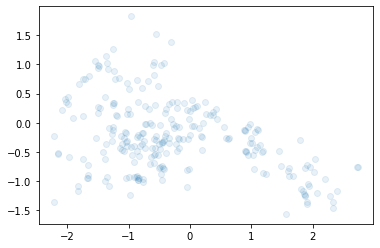

In [42]:
plt.scatter(compressed_weights_kde_exact[:, 0], compressed_weights_kde_exact[:, -3], alpha=0.1)

# Lets optimise the variances

In [43]:
#lets compress some samples
#### sample weights with compression algorithm
from tqdm.notebook import trange
from rec.beamsearch.Coders.Encoder_Empirical import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
from models.BNNs.BNN_for_HMC import BNN_for_HMC
import pyro.distributions as dist

In [44]:
dummy_model = BNN_for_HMC(alpha=alpha, beta=beta, num_nodes=num_nodes)

In [45]:
# import pickle as pkl
# pkl.dump(emp_samples, open("PickledStuff/emp_samples.pkl", "wb"))
# pkl.dump(x_data, open("PickledStuff/x_data.pkl", "wb"))
# pkl.dump(y_data, open("PickledStuff/y_data.pkl", "wb"))
# pkl.dump(ys, open("PickledStuff/ys.pkl", "wb"))
# pkl.dump(xs, open("PickledStuff/xs.pkl", "wb"))

In [46]:
emp_dist = dist.Empirical(samples, log_weights=torch.ones(samples.shape[0]))

In [47]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
dummy_encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)

z_sample = emp_dist.mean
omega = 5
n_trajectories = 64
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, kl_q_p, n_trajectories, prior_var)
aux_vars = emp_opt.run_optimiser(epochs=5000)

The mean loss is 4.69218. The mean KL is: 5.46517: 100%|██████████| 5000/5000 [06:32<00:00, 12.74it/s]


# Let's use the EMP scheme

In [48]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 250
compressed_weights_emp_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_low_eps.append(w[0])

pred_list_emp_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = ys.to(device), samples=compressed_weights_emp_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

  0%|          | 0/250 [00:00<?, ?it/s]

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


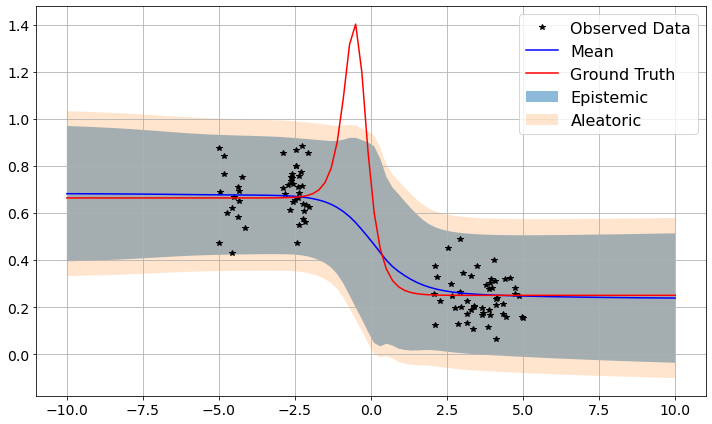

In [49]:
plot_preds(pred_list_emp_low_eps)

  0%|          | 0/250 [00:00<?, ?it/s]

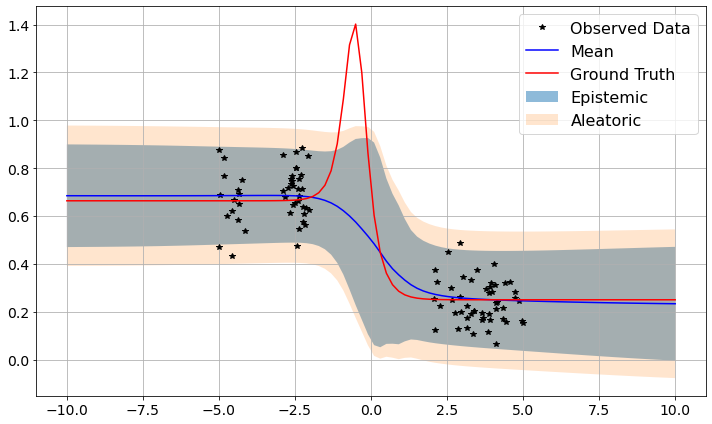

In [50]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 250
compressed_weights_emp_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_med_eps.append(w[0])

pred_list_emp_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_emp_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_med_eps)

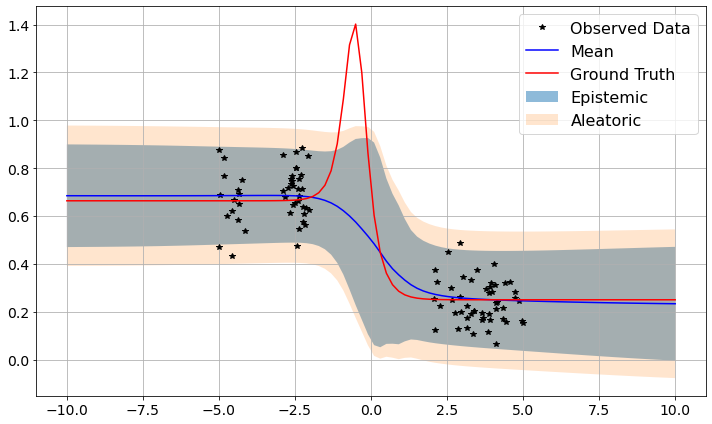

In [51]:
plot_preds(pred_list_emp_med_eps)

  0%|          | 0/250 [00:00<?, ?it/s]

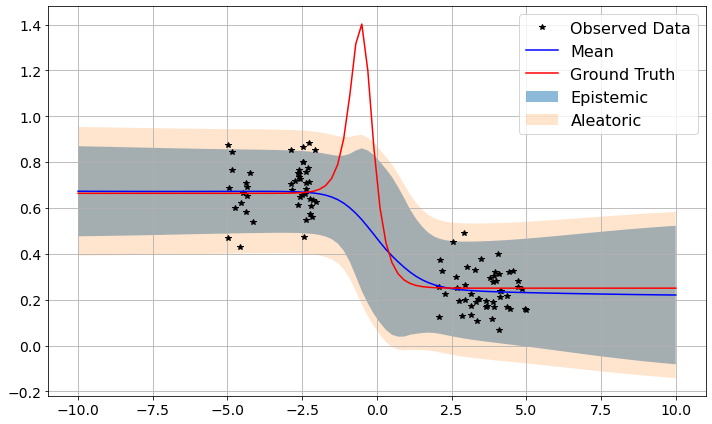

In [52]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 250
compressed_weights_emp_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_high_eps.append(w[0])

pred_list_emp_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_emp_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_high_eps)

# Let's try the KDE coder

In [53]:
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.KDEPosterior import KDEPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.beamsearch.Coders.Encoder_KDE import EncoderKDE

In [54]:
num_compressed_samples = 500
compressed_weights_kde_exact = KDE_target.sample((num_compressed_samples,))

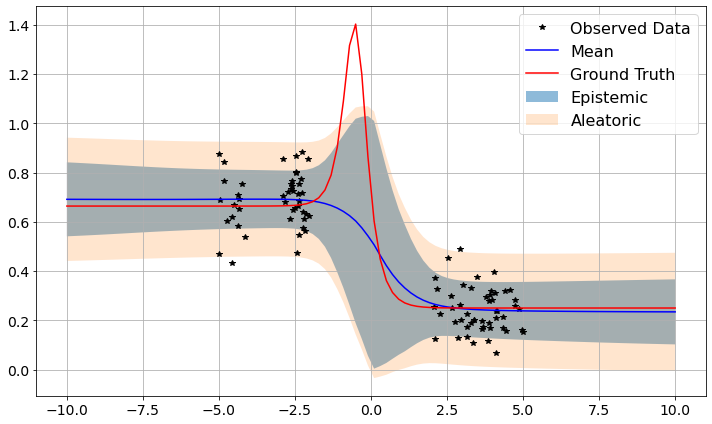

In [55]:
pred_list_kde_exact, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_exact,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_exact)

In [56]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 250
compressed_weights_kde_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_low_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

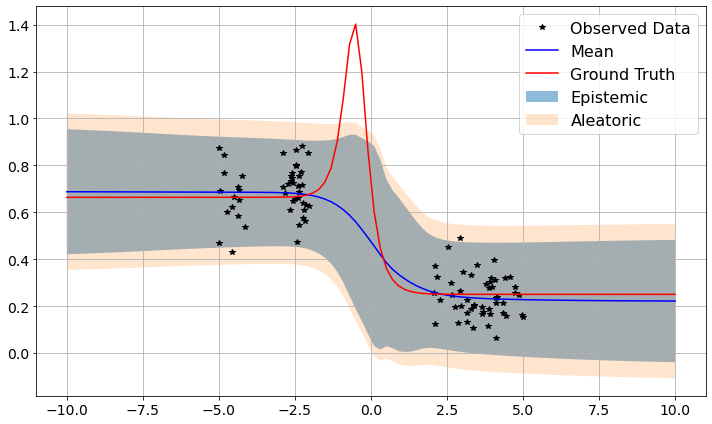

In [57]:
pred_list_kde_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_low_eps)


In [58]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 250
compressed_weights_kde_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_med_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

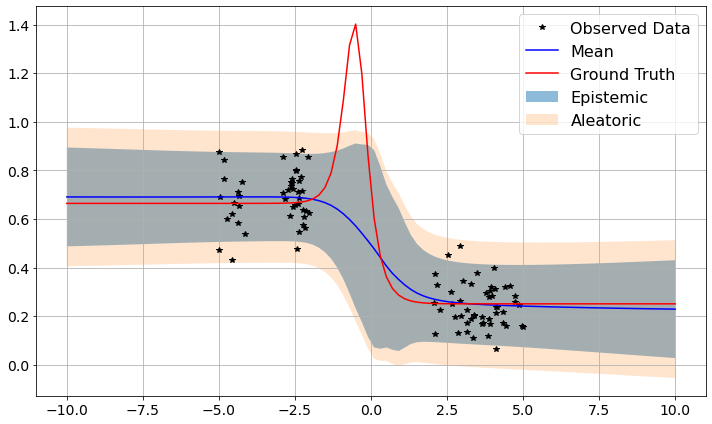

In [59]:
pred_list_kde_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_med_eps)


In [60]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 250
compressed_weights_kde_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_high_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

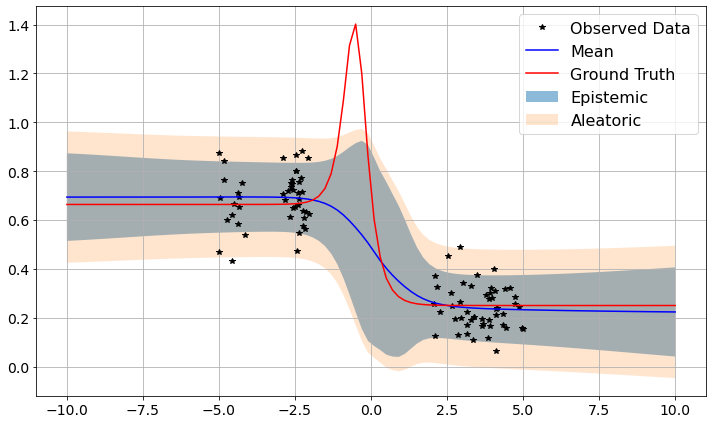

In [61]:
pred_list_kde_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_high_eps)


# Let's Compute some Statistics

In [62]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [63]:
compute_gmm_lp(params_hmc_gpu, x_test, y_test)

tensor(157.3071)

In [64]:
compute_gmm_lp(params_hmc_gpu, x_data, y_data)

tensor(86.8398)

In [65]:
compute_gmm_lp(compressed_weights_emp_low_eps, x_test, y_test)

tensor(117.9036)

In [66]:
compute_gmm_lp(compressed_weights_emp_med_eps, x_test, y_test)

tensor(131.7273)

In [67]:
compute_gmm_lp(compressed_weights_emp_high_eps, x_test, y_test)

tensor(129.7028)

In [68]:
compute_gmm_lp(compressed_weights_kde_exact, x_test, y_test)

tensor(151.8553)

In [69]:
compute_gmm_lp(compressed_weights_kde_low_eps, x_test, y_test)

tensor(123.0284)

In [70]:
compute_gmm_lp(compressed_weights_kde_med_eps, x_test, y_test)

tensor(134.5398)

In [71]:
compute_gmm_lp(compressed_weights_kde_high_eps, x_test, y_test)

tensor(139.3759)

In [73]:
# dump the important stuff
import pickle as pkl
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/hmc_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(samples, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/HMC_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(KDE_target, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/HMC_KDE_target_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_emp_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_emp_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_emp_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))
pkl.dump(compressed_weights_kde_exact, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_kde_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_kde_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_kde_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))

In [74]:
ELBO_BETA

2